# Examples for OptPulseProcessor

In [1]:
from numpy import pi
from qutip.qip.device import OptPulseProcessor
from qutip.qip import QubitCircuit, expand_operator
from qutip import sigmaz, sigmax, basis, fidelity, identity, toffoli, tensor

The `qutip.OptPulseProcessor` is a the simulator integrated with the optimal pulse algorithm from the `qutip.control` module. It is a subclass of `qutip.Processor` and is equipted with a method to find the pulse sequence for a `qutip.QubitCircuit` or a list of `qutip.Qobj`.

## Single-qubit gate
Like the `Circuitprocessor`, we need to first define the available Hamiltonians in the system. The `OptPulseProcessor` has one more parameter, that is the drift Hamiltonian, who has no time-dependent coefficients and thus won't be optimized.

In [2]:
N = 1
# Drift Hamiltonian
H_d = sigmaz()
# The (single) control Hamiltonian
H_c = [sigmax()]
processor = OptPulseProcessor(N, drift=H_d, ctrls=H_c)

The method load_circuit calls `qutip.control.optimize_pulse_unitary` and return the pulse coefficients.

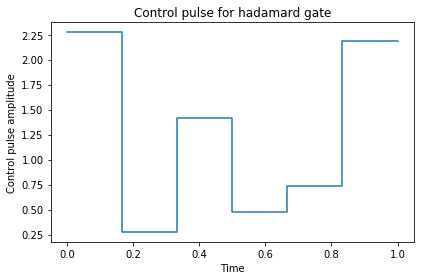

In [3]:
qc = QubitCircuit(N)
qc.add_gate("SNOT", 0)

# This method calls optimize_pulse_unitary
tlist, coeffs = processor.load_circuit(qc, min_grad=1e-20, init_pulse_type='RND',
                                       num_tslots=6, evo_time=1)
processor.plot_pulses(title="Control pulse for hadamard gate");

Like the `Processor`, the simulation is calculated with the QuTiP solver. The method `run_state` calls `mesolve` and return the result. One can also add noise to see the change in the fidelity.

In [4]:
rho0 = basis(2,1)
plus = (basis(2,0) + basis(2,1)).unit()
minus = (basis(2,0) - basis(2,1)).unit()
result = processor.run_state(rho0=rho0)
result.states[-3]
print("Fidelity:", fidelity(result.states[-1], minus))

# add noise
processor.t1 = 40.0
result = processor.run_state(rho0=rho0)
print("Fidelity with qubit relaxation:", fidelity(result.states[-1], minus))

Fidelity: 1.000000007450267
Fidelity with qubit relaxation: 0.9933587820957896


## Multi-qubit gate

In the following example, we use `OptPulseProcessor` to find the optmal control pulse of a multi-qubit circuit. For simplicity, the circuit contains only one toffoli gate.

In [5]:
toffoli()

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]

We have single qubit control $\sigma_x$ and $\sigma_z$, with the argument `expand_type="periodic"`, it creates 3 operators each targeted on one qubit.

In [6]:
N = 3
H_d = tensor([identity(2)] * 3)
test_processor = OptPulseProcessor(N, H_d, [])
test_processor.add_ctrl(sigmaz(), cyclic_permutation=True)
test_processor.add_ctrl(sigmax(), cyclic_permutation=True)

The interaction is generated by $\sigma_x\sigma_x$ between the qubit 0 & 1 and qubit 1 & 2. `expand_operator` can be used to expand the operator to a larger dimension with given target qubits.

In [7]:
sxsx = tensor([sigmax(),sigmax()])
sxsx01 = expand_operator(sxsx, N=3, targets=[0,1])
sxsx12 = expand_operator(sxsx, N=3, targets=[1,2])
test_processor.add_ctrl(sxsx01)
test_processor.add_ctrl(sxsx12)

Find the optimal pulse with 6 time slots. Instead of a `QubitCircuit`, a list of operators can also be given as an input.

********** Gate 0 **********
Final fidelity error 9.345891616163726e-09
Final gradient normal 6.307366865665837e-06
Terminated due to function converged
Number of iterations 324


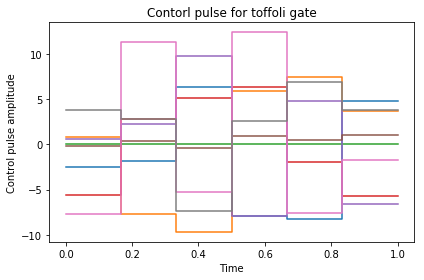

In [8]:
test_processor.load_circuit([toffoli()], num_tslots=6, evo_time=1, verbose=True);

test_processor.plot_pulses(title="Contorl pulse for toffoli gate");

## Merging a quantum circuit
If there are multiple gates in the circuit, we can choose if we want to first to merge them and then find the pulse for the merged unitary.

In [9]:
qc = QubitCircuit(N=3)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("RX", targets=2, arg_value=pi/4)
qc.add_gate("RY", targets=1, arg_value=pi/8)

********** Gate 0 **********
Final fidelity error 0.2928918368808169
Final gradient normal 2.2651082806004404e-05
Terminated due to function converged
Number of iterations 121
********** Gate 1 **********
Final fidelity error 3.0240254744740014e-11
Final gradient normal 4.5803863470634595e-05
Terminated due to Goal achieved
Number of iterations 11
********** Gate 2 **********
Final fidelity error 1.547413197577896e-09
Final gradient normal 1.3147760774865452e-05
Terminated due to function converged
Number of iterations 22


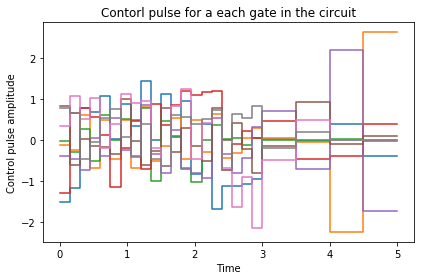

In [10]:
setting_args = {"CNOT": {"num_tslots": 20, "evo_time": 3},
                "RX": {"num_tslots": 2, "evo_time": 1},
                "RY": {"num_tslots": 2, "evo_time": 1}}

test_processor.load_circuit(qc, merge_gates=False, setting_args=setting_args, verbose=True);
test_processor.plot_pulses(title="Contorl pulse for a each gate in the circuit");

********** Gate 0 **********
Final fidelity error 1.008430878357558e-06
Final gradient normal 2.5791858152845152e-05
Terminated due to function converged
Number of iterations 234


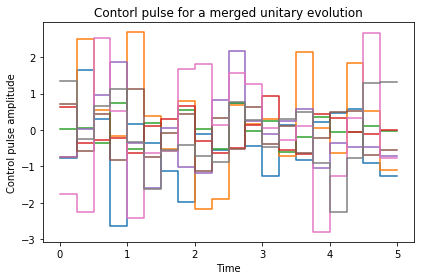

In [11]:
qc = QubitCircuit(N=3)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("RX", targets=2, arg_value=pi/4)
qc.add_gate("RY", targets=1, arg_value=pi/8)
test_processor.load_circuit(qc, merge_gates=True, verbose=True, num_tslots=20, evo_time=5);
test_processor.plot_pulses(title="Contorl pulse for a merged unitary evolution");

In [12]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.0.dev0+c50c4bc9
Numpy,1.16.2
SciPy,1.2.1
matplotlib,3.0.3
Cython,0.29.12
Number of CPUs,12
BLAS Info,INTEL MKL
IPython,7.4.0
Python,"3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]"
OS,nt [win32]
